# Denoising experiments

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn

## Step 1: Data Analysis

In [2]:
df = pd.read_csv("OpenBCI-RAW.txt", comment='%')
df = df.rename(columns=lambda x: x.strip())
df = df[5:]
df.head()

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8,...,Other.3,Other.4,Other.5,Other.6,Analog Channel 0,Analog Channel 1,Analog Channel 2,Timestamp,Other.7,Timestamp (Formatted)
5,6.0,60097.470593,63373.498723,-30929.204038,-2449.259454,17784.076069,9420.790901,28911.824991,4166.231056,33888.016211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.702
6,8.0,60103.214991,63383.400546,-30918.229332,-2395.458805,17784.970139,9449.512893,28909.790982,4172.154268,33891.391324,...,15.5,48.0,3.0,104.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.710
7,10.0,60103.013826,63379.265473,-30916.977634,-2425.164273,17783.964310,9441.689782,28909.813334,4172.310730,33902.075458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.718
8,12.0,60108.221782,63382.618234,-30913.222541,-2382.695959,17795.654273,9439.745181,28930.667511,4179.083309,33905.584682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.726
9,14.0,60104.354930,63375.599787,-30920.822134,-2410.725046,17791.988586,9438.806407,28925.034872,4171.573123,33920.739164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.735


In [3]:
df.columns

Index(['Sample Index', 'EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2',
       'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6',
       'EXG Channel 7', 'EXG Channel 8', 'EXG Channel 9', 'EXG Channel 10',
       'EXG Channel 11', 'EXG Channel 12', 'EXG Channel 13', 'EXG Channel 14',
       'EXG Channel 15', 'Accel Channel 0', 'Accel Channel 1',
       'Accel Channel 2', 'Other', 'Other.1', 'Other.2', 'Other.3', 'Other.4',
       'Other.5', 'Other.6', 'Analog Channel 0', 'Analog Channel 1',
       'Analog Channel 2', 'Timestamp', 'Other.7', 'Timestamp (Formatted)'],
      dtype='object')

In [4]:
def plot_eeg(data, figsize=(20, 15), title=None):
    if isinstance(data, torch.Tensor):
        data = data.detach().numpy()

    num_plots = data.shape[1]

    fig, ax = plt.subplots(num_plots, 1, figsize=figsize)
    x = range(len(data))

    if data.ndim == 1:
        data = data[:, None]

    if num_plots == 1:
        ax = [ax]
        # data = data.reshape(1, -1)

    for i in range(num_plots):
        ax[i].plot(x, data[:, i], linewidth=0.5)
        ax[i].set_xlabel("Iter")
        ax[i].set_ylabel("Voltage ($\mu V$)")
        if title:
            ax[i].set_title(title)
        else:
            ax[i].set_title(df.columns[start_idx+i])

    plt.tight_layout()
    plt.show()

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

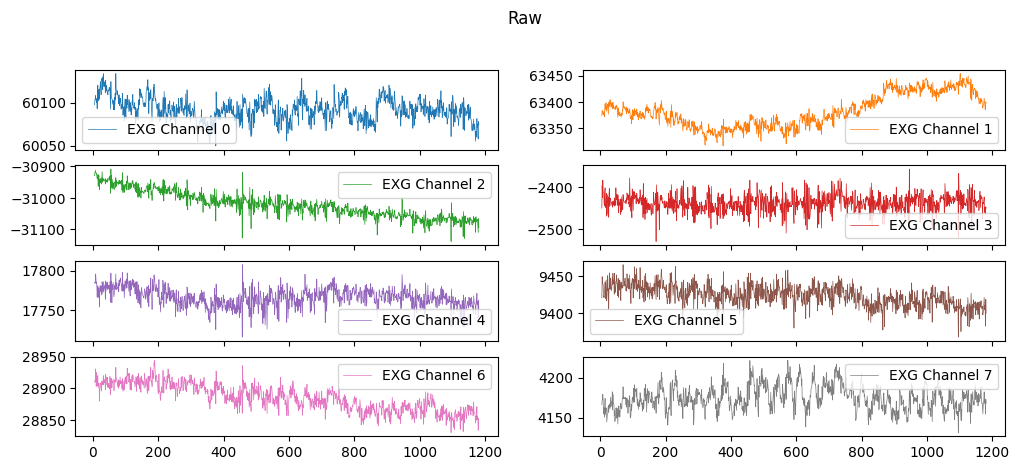

In [5]:
start_idx = 1
end_idx = start_idx + 8
raw_data = df.iloc[:, start_idx:end_idx]
# plot_eeg(raw_data)

raw_data.plot(title="Raw", subplots=True, layout=(5, 2), figsize=(12, 6), linewidth=0.5)

## 1. 1D Convolutions

In [6]:
data_conv_df = df.iloc[:, 1]
data_conv_df.head()

5    60097.470593
6    60103.214991
7    60103.013826
8    60108.221782
9    60104.354930
Name: EXG Channel 0, dtype: float64

In [7]:
data_conv = torch.tensor(data_conv_df.to_numpy(), dtype=torch.float32).view(1, 1, -1)

In [8]:
class ConvolutionNoiseReductor(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(ConvolutionNoiseReductor, self).__init__()
        self.conv = nn.Conv1d(1, 1, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.conv(x)
        return x

In [9]:
model = ConvolutionNoiseReductor(kernel_size=256, stride=16)

result = model(data_conv)

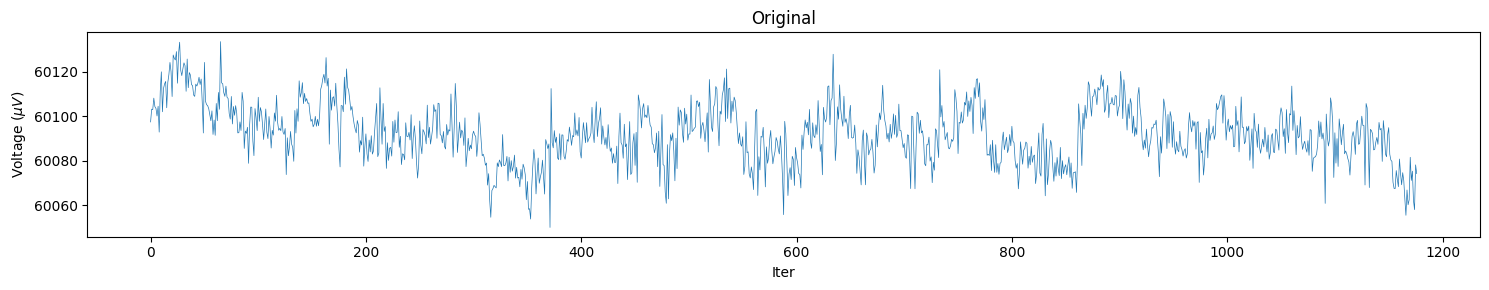

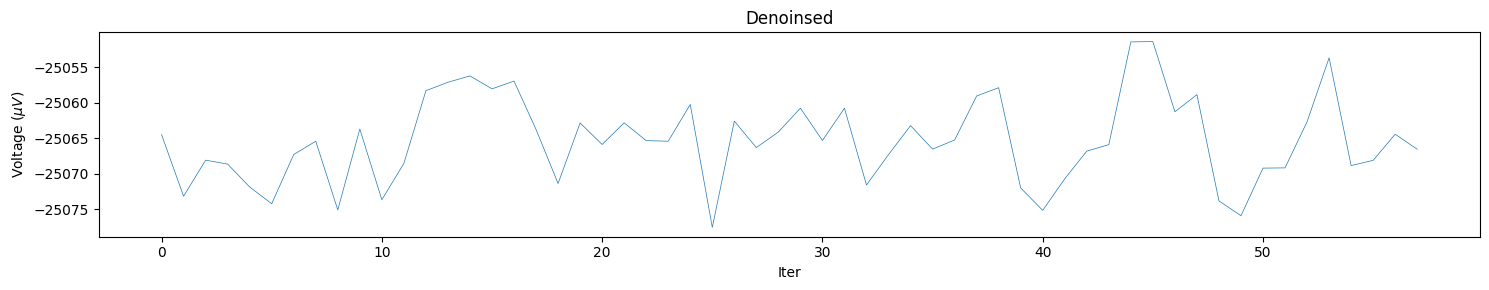

In [10]:
plot_eeg(df["EXG Channel 0"].to_numpy()[..., np.newaxis], figsize=(15, 3), title="Original")
plot_eeg(result[0, :, :].T, figsize=(15, 3), title="Denoinsed")

**Convolutions ❌** \\
One major flaw of using convolutions for EEG signal denoising is that the values have a very large shift after applying the convolution.

## 2. ICA

In [34]:
ica_data = df.iloc[:, 1:9]
ica_data.head()

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7
5,60097.470593,63373.498723,-30929.204038,-2449.259454,17784.076069,9420.790901,28911.824991,4166.231056
6,60103.214991,63383.400546,-30918.229332,-2395.458805,17784.970139,9449.512893,28909.790982,4172.154268
7,60103.013826,63379.265473,-30916.977634,-2425.164273,17783.964310,9441.689782,28909.813334,4172.310730
8,60108.221782,63382.618234,-30913.222541,-2382.695959,17795.654273,9439.745181,28930.667511,4179.083309
9,60104.354930,63375.599787,-30920.822134,-2410.725046,17791.988586,9438.806407,28925.034872,4171.573123


In [12]:
from sklearn.decomposition import FastICA

In [36]:
ica = FastICA(n_components=7, random_state=42)
components = ica.fit_transform(ica_data)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


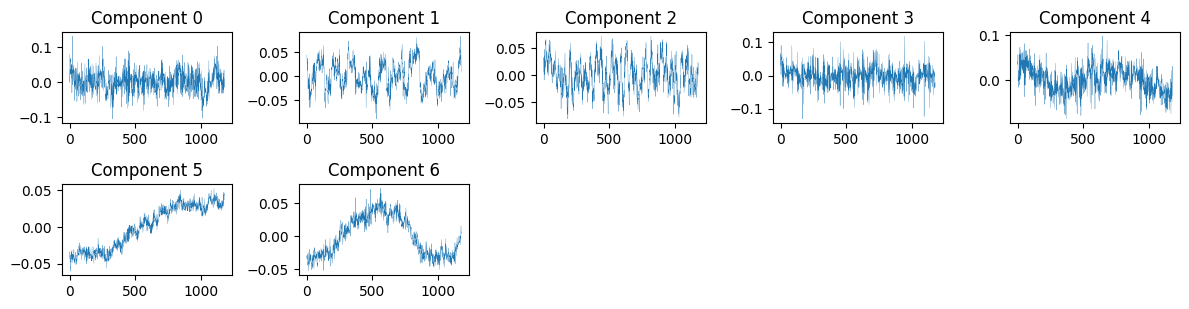

In [37]:
plt.figure(figsize=(12, 6))
for i, component in enumerate(components.T):
    plt.subplot(4, 5, i + 1)
    plt.plot(component, linewidth=0.2)
    plt.title(f"Component {i}")
plt.tight_layout()
plt.show()

In [40]:
bad_components = [0, 1, 2, 3, 4]
components[:, bad_components] = 0
cleaned_signal = ica.inverse_transform(components)
df_cleaned = pd.DataFrame(cleaned_signal, columns=ica_data.columns)

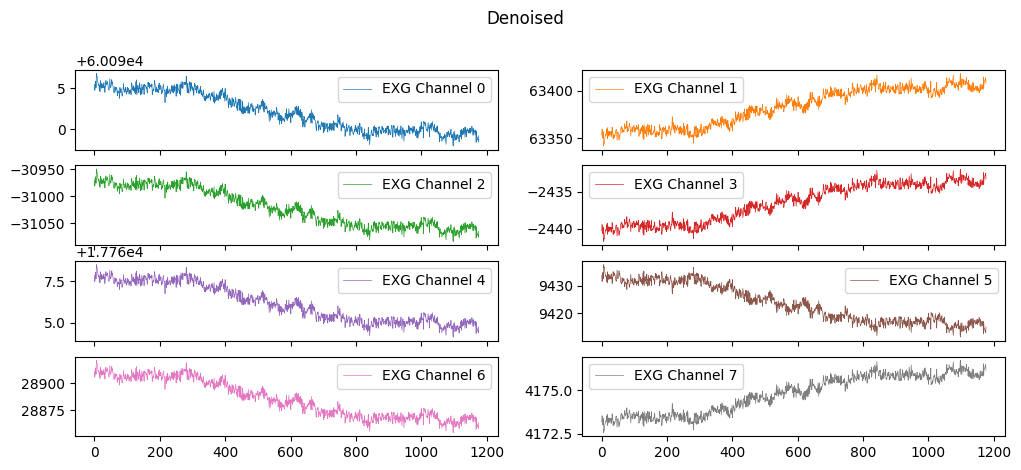

In [41]:
df_cleaned.plot(title="Denoised", subplots=True, layout=(5, 2), figsize=(12, 6), linewidth=0.5)
plt.show()